In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from hopnet.utils.dataset import PreloadedDataset
from hopnet.utils.train import train_hopfield, train_iterative
from hopnet.utils.transforms import mask_center_column, mask_center_row, downsample_and_upsample, add_salt_and_pepper_noise
from hopnet.utils.eval import evaluate_mask
from hopnet.activations import HopfieldActivation, StochasticHopfieldActivation, Tanh
from hopnet.energies import ErrorEnergy, LyapunovEnergy
from hopnet.models import HopfieldNet, PCHNet, PCHNetV2

In [3]:
# Sets program to utilise GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    HopfieldActivation(prefer=-1), # set images to -1 or 1
])
dataset = datasets.MNIST(root="datasets/", train=True, transform=transform, download=True)

# reduce dataset size by either ratio or specific number of images
# DATA_RATIO = 0.0015 # portion of dataset to use, largest that works so far is 0.002.
# dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * DATA_RATIO)))
dataset = torch.utils.data.Subset(dataset, range(60)) # Specifies the number of images to use from the dataset

train_dataset = PreloadedDataset.from_dataset(dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10
time.sleep(0.1)
train_len = len(train_dataset)
print(f'INPUT_SHAPE: {INPUT_SHAPE}')
print(f'Loaded MNIST dataset with {train_len} training samples')#and {len(val_dataset)} validation samples')


INPUT_SHAPE: torch.Size([1, 28, 28])
Loaded MNIST dataset with 60 training samples


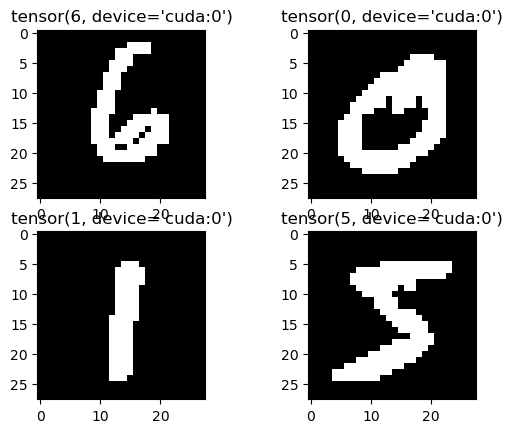

In [5]:
# Show 4 random images from the training dataset in grid
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        idx = torch.randint(0, len(train_dataset), (1,)).item()
        image = train_dataset[idx][0].squeeze().cpu()
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(train_dataset[idx][1])
plt.show()

In [7]:
torch.manual_seed(42)
LOG_DIR = "out/logs"
MODEL_DIR = "out/weights"
size = 1
for dim in INPUT_SHAPE:
    size *= dim

"""
Specify your energy function.
Currently available:
    - ErrorEnergy(actv_fn=None)
    - LyapunovEnergy()
"""
energy_fn = ErrorEnergy(actv_fn=torch.tanh)

"""
Specify your activation function.
Currently available:
    - HopfieldActivation(prefer) where prefer is either -1 or 1
    - StochasticHopfieldActivation(temperature) where temperature is a float, e.g. 1.0
"""
actv_fn = StochasticHopfieldActivation(temperature=1.0)

"""
Initialise model
Currently available:
    - HopfieldNet(size, energy_fn, actv_fn, bias=True, steps=10)
    - PCHNet(size, energy_fn, actv_fn, mu=1.0, bias=True, steps=10)
    - PCHNetV2(size, energy_fn, actv_fn, mu=1.0, bias=True, steps=10)
"""
model = HopfieldNet(size, energy_fn, actv_fn, bias=True, steps=10).to(device)
step = 0

In [8]:
# Good parameters for ErrorEnergy (max 90 images)
LR = 3e-4 # 3e-4 seems effective for minimising energy, 1.0 is good for Gardner mode
BATCH_SIZE= 1 # smaller batch sizes seem to work better
EPOCHS = 500
MODE = 'energy' # 'default', 'gardner', 'energy', 'reconstruction_err'
ACTV_FN = model.actv_fn.__class__.__name__
MODEL_TYPE = model.__class__.__name__
UNTRAIN_AFTER = None
UNTRAIN_CONST = 1.0
MODEL_NAME = f"train_len{train_len}-{MODEL_TYPE}-{ACTV_FN}-{MODE}-BS{BATCH_SIZE}-LR{LR}"
if UNTRAIN_AFTER is not None:
    MODEL_NAME += f"-UNTRAIN{UNTRAIN_AFTER}_{UNTRAIN_CONST}"
SAVE_MODEL = True
plot=False # plots the energy and loss graphs using tensorboard

optimiser = optim.AdamW(model.parameters(), lr=LR, betas=(0.0, 0.999), weight_decay=0.0) # Convergence is sensitive to the betas used. (0.0, 0.999) seems to work for all training modes
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
criterion = nn.MSELoss()

scheduler=None
# scheduler = ReduceLROnPlateau(optimiser, mode='min', min_lr=3e-9, factor=0.75, patience=5, verbose=True)

In [11]:
# Weight set rule. Hopfield Rule. Only use with hopfieldNetwor
train_hopfield(model, train_loader, MODEL_NAME, flatten=True, model_dir=MODEL_DIR, log_dir=LOG_DIR, save_model=SAVE_MODEL, device=device)

In [9]:
energy, loss, step = train_iterative(model, 
                             train_loader, 
                             optimiser, 
                             MODEL_NAME, 
                             EPOCHS, 
                             criterion=criterion,
                             scheduler=scheduler, 
                             mode=MODE,
                             flatten=True, 
                             step=step, 
                             model_dir=MODEL_DIR,
                             save_model=SAVE_MODEL,
                             untrain_after=UNTRAIN_AFTER,
                             untrain_const=UNTRAIN_CONST,
                             eval_loss_every=1,
                             plot=plot,
                             device=device)

Best train loss: 1.4778911565639534


In [11]:
# Load best model
model.load_state_dict(torch.load(f"{MODEL_DIR}/{MODEL_NAME}.pth"))

<All keys matched successfully>

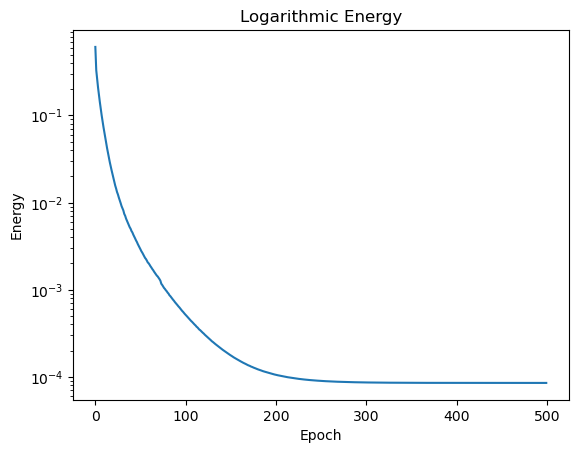

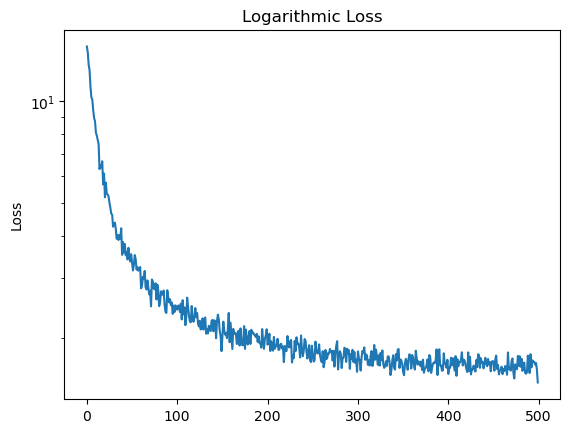

In [10]:
# plot energy over epochs
plt.plot(energy)
plt.yscale("log") # Uncomment if graphs dont display because of negative energy values
plt.title("Logarithmic Energy")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()

plt.plot(loss)
plt.yscale("log")
plt.title("Logarithmic Loss")
plt.ylabel("Loss")
plt.show()


c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


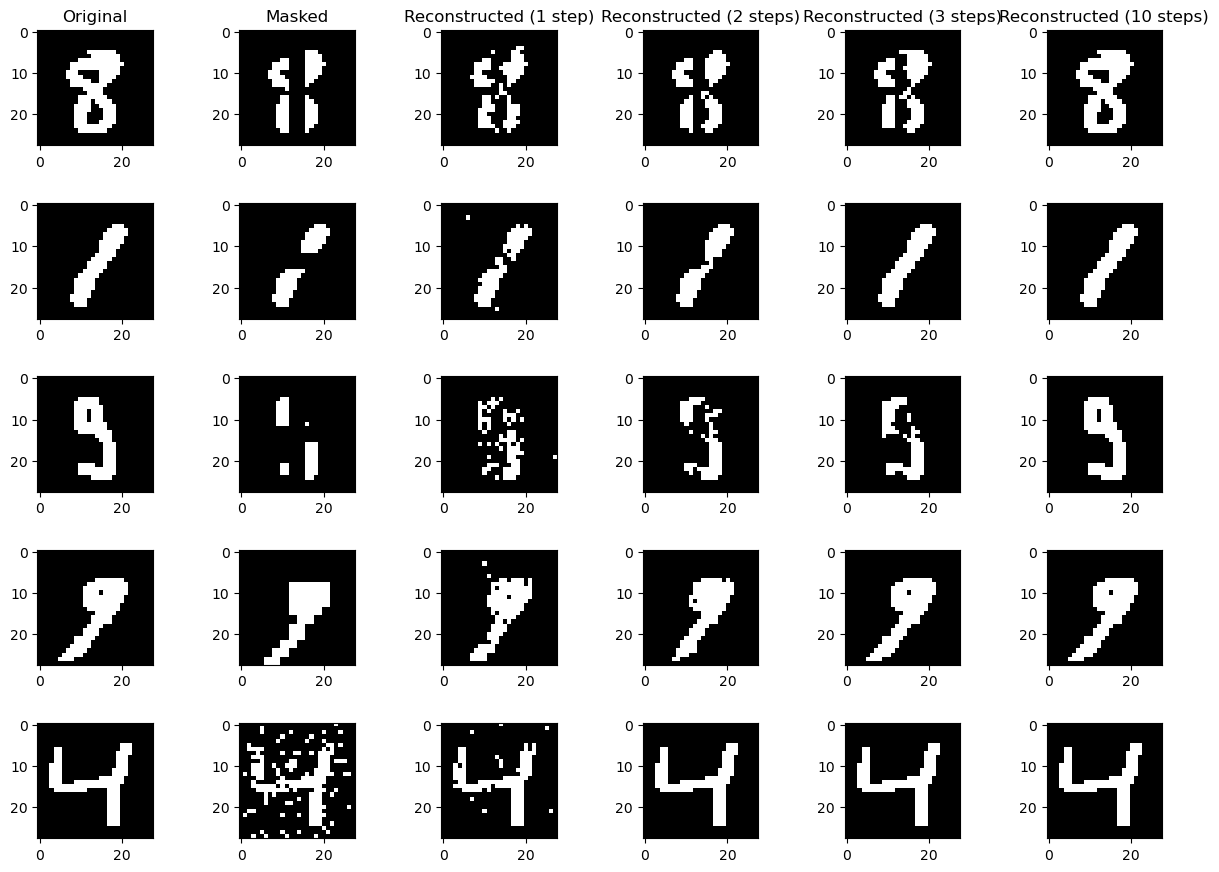

In [12]:
# Show 4 examples of original, masked and reconstructed images, with extra spacing between subplots
steps = (1, 2, 3)
width = 0.2
length = 5
if len(train_dataset) < 4:
    length = len(train_dataset)

# Randomly select 4 images from the training dataset
idxs = []
while len(idxs) < length:
    idx = torch.randint(0, len(train_dataset), (1,)).item()
    if idx not in idxs:
        idxs.append(idx)

# noise each image differently and show their reconstruction through the model's iteration.
fig, ax = plt.subplots(length, 6)
for i in range(length):
    original = train_dataset[idxs[i]][0]
    if i == 0:
        masked = mask_center_column(original.unsqueeze(0), width)
    elif i == 1:
        masked = mask_center_row(original.unsqueeze(0), width)
    elif i == 2:
        masked = mask_center_row(mask_center_column(original.unsqueeze(0), width), width)
    elif i == 3:
        masked = downsample_and_upsample(original.unsqueeze(0), 2)
    elif i == 4:
        masked = add_salt_and_pepper_noise(original.unsqueeze(0), 0.1)
    masked = torch.tensor(masked).squeeze(0).squeeze(0)
    reconstructed_1 = model(masked.view(-1), steps=steps[0]).view(INPUT_SHAPE)
    reconstructed_2 = model(masked.view(-1), steps=steps[1]).view(INPUT_SHAPE)
    reconstructed_3 = model(masked.view(-1), steps=steps[2]).view(INPUT_SHAPE)
    reconstructed_fin = model(masked.view(-1)).view(INPUT_SHAPE)
    ax[i, 0].imshow(original.squeeze(0).cpu(), cmap="gray")
    ax[i, 1].imshow(masked.cpu(), cmap="gray")
    ax[i, 2].imshow(reconstructed_1.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 3].imshow(reconstructed_2.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 4].imshow(reconstructed_3.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 5].imshow(reconstructed_fin.detach().squeeze(0).cpu(), cmap="gray")
    if i == 0:
        ax[i, 0].set_title("Original")
        ax[i, 1].set_title("Masked")
        ax[i, 2].set_title(f"Reconstructed ({steps[0]} step)")
        ax[i, 3].set_title(f"Reconstructed ({steps[1]} steps)")
        ax[i, 4].set_title(f"Reconstructed ({steps[2]} steps)")
        ax[i, 5].set_title(f"Reconstructed ({model.steps} steps)")
    # Add extra spacing between subplots
    # Make images bigger
    fig.set_size_inches(15.5, 10.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.5)


plt.show()